# Data Exploration

## Dataset information
The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

## Source
Luis Candanedo, luismiguel.candanedoibarra '@' umons.ac.be, University of Mons (UMONS).

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
#use widget instead of inline to make the plot interactive
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [20, 10]
from sklearn import preprocessing

In [2]:
df = pd.read_csv('data/energydata_complete.csv', parse_dates=['date'])
df = df.set_index(['date'],drop=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [4]:
df.head(4)

Appliances  lights     T1       RH_1    T2       RH_2  \
date                                                                         
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   

                        T3       RH_3         T4       RH_4  ...         T9  \
date                                                         ...              
2016-01-11 17:00:00  19.79  44.730000  19.000000  45.566667  ...  17.033333   
2016-01-11 17:10:00  19.79  44.790000  19.000000  45.992500  ...  17.066667   
2016-01-11 17:20:00  19.79  44.933333  18.926667  45.890000  ...  17.000000   
2016-01-11 17:30:00  19.79  45.000000  18.890000  45.723333  ...  17.000000   

                      RH_9     T_out  Press_mm_hg  RH_out  Windspeed  \
date                                                                   
2016-01-11 17:00:00  45.53  6.600000        733.5    92.0   7.000000   
2016-01-11 17:10:00  45.56  6.483333        733.6    92.0   6.666667   
2016-01-11 17:20:00  45.50  6.366667        733.7    92.0   6.333333   
2016-01-11 17:30:00  45.40  6.250000        733.8    92.0   6.000000   

                     Visibility  Tdewpoint        rv1        rv2  
date                                                              
2016-01-11 17:00:00   63.000000        5.3  13.275433  13.275433  
2016-01-11 17:10:00   59.166667        5.2  18.606195  18.606195  
2016-01-11 17:20:00   55.333333        5.1  28.642668  28.642668  
2016-01-11 17:30:00   51.500000        5.0  45.410389  45.410389  

[4 rows x 28 columns]

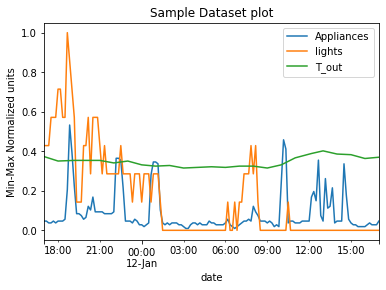

In [5]:
min_max_df=(df-df.min())/(df.max()-df.min())
min_max_df.loc['2016-01-11 17:00:00':'2016-01-12 17:00:00'][['Appliances','lights','T_out']].plot()
plt.ylabel(r'Min-Max Normalized units')
plt.title('Sample Dataset plot')
plt.show()

## Feature Engineering

In [6]:
# Add previous energy consumption in 10minute intervals
for i in range(6):
    i+=1
    df[f'Appliances_{i}0'] = df['Appliances'].shift(i)
df = df.dropna(axis=0)

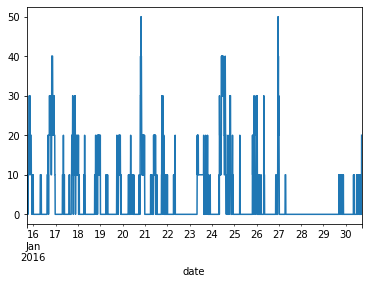

In [7]:
plt.figure()
df.loc['2016-01-15 17:00:00':'2016-01-30 17:00:00']['lights'].plot()
plt.show()

Looking at a sample section, 8am to 11pm are durations when the lights are usually on. this can change in different hourseholds. since we are using this dataset which is from a single household, is safe to use this information to assign day/night categorization

In [8]:
df['hour'] = df.index.hour
df['is_day'] = df.hour.apply(lambda x: 1 if (x >= 8 and x <= 22) else 0)
df['is_night'] = df.is_day.apply(lambda x: int(not(x)))
df = df.drop(['hour'],axis=1)

In [9]:
df['T_mean']=df[[f'T{s+1}' for s in range(9)]].mean(axis=1)
df['RH_mean']=df[[f'RH_{s+1}' for s in range(9)]].mean(axis=1)
df['T_diff']=np.where(df.T_mean > df.T_out, 1, -1)
df['RH_diff']=np.where(df.RH_mean > df.RH_out, 1, -1)

In [10]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm',axis=None).set_precision(2)

In [11]:
# Check if there are null values
df.isna().sum().any()

False

In [12]:
# Normalize the data
from sklearn.preprocessing import MaxAbsScaler

# create a scaler object
scaler = MaxAbsScaler()
# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_norm

Appliances    lights        T1      RH_1        T2      RH_2        T3  \
0        0.055556  0.714286  0.757426  0.722327  0.643072  0.794265  0.676905   
1        0.055556  0.714286  0.756156  0.719066  0.643072  0.794265  0.674853   
2        0.055556  0.571429  0.753618  0.719658  0.643072  0.793075  0.674853   
3        0.064815  0.571429  0.756156  0.727431  0.644077  0.792480  0.676905   
4        0.212963  1.000000  0.758822  0.723853  0.648320  0.792480  0.676905   
...           ...       ...       ...       ...       ...       ...       ...   
19724    0.092593  0.000000  0.973597  0.734848  0.867143  0.750102  0.930360   
19725    0.083333  0.000000  0.971059  0.733902  0.862588  0.751071  0.928080   
19726    0.250000  0.142857  0.971059  0.735427  0.858387  0.763361  0.925229   
19727    0.388889  0.142857  0.971059  0.741635  0.851200  0.768134  0.919756   
19728    0.398148  0.142857  0.971059  0.735480  0.846186  0.766982  0.917476   

           RH_3        T4      RH_4  ...  Appliances_30  Appliances_40  \
0      0.895076  0.720992  0.896261  ...       0.046296       0.046296   
1      0.895076  0.720992  0.897697  ...       0.055556       0.046296   
2      0.892883  0.720992  0.896261  ...       0.046296       0.055556   
3      0.894345  0.720992  0.902264  ...       0.055556       0.046296   
4      0.895076  0.720992  0.908788  ...       0.055556       0.055556   
...         ...       ...       ...  ...            ...            ...   
19724  0.820586  0.942748  0.892347  ...       0.111111       0.166667   
19725  0.821782  0.942748  0.892347  ...       0.101852       0.111111   
19726  0.831085  0.942748  0.895087  ...       0.083333       0.101852   
19727  0.823111  0.942748  0.896261  ...       0.092593       0.083333   
19728  0.820453  0.942748  0.899654  ...       0.083333       0.092593   

       Appliances_50  Appliances_60  is_day  is_night    T_mean   RH_mean  \
0           0.055556       0.055556     1.0       0.0  0.661846  0.860043   
1           0.046296       0.055556     1.0       0.0  0.660983  0.860294   
2           0.046296       0.046296     1.0       0.0  0.660983  0.861970   
3           0.055556       0.046296     1.0       0.0  0.661803  0.864490   
4           0.046296       0.055556     1.0       0.0  0.662857  0.867502   
...              ...            ...     ...       ...       ...       ...   
19724       0.203704       0.092593     1.0       0.0  0.965596  0.696367   
19725       0.166667       0.203704     1.0       0.0  0.962221  0.695635   
19726       0.111111       0.166667     1.0       0.0  0.958786  0.697870   
19727       0.101852       0.111111     1.0       0.0  0.951556  0.697938   
19728       0.083333       0.101852     1.0       0.0  0.944869  0.697163   

       T_diff  RH_diff  
0         1.0     -1.0  
1         1.0     -1.0  
2         1.0     -1.0  
3         1.0     -1.0  
4         1.0     -1.0  
...       ...      ...  
19724     1.0     -1.0  
19725     1.0     -1.0  
19726     1.0     -1.0  
19727     1.0     -1.0  
19728     1.0     -1.0  

[19729 rows x 40 columns]

In [13]:
df_norm.describe()

Appliances        lights            T1          RH_1            T2  \
count  19729.000000  19729.000000  19729.000000  19729.000000  19729.000000   
mean       0.090470      0.054177      0.825861      0.635383      0.681307   
std        0.094942      0.113115      0.061158      0.062790      0.073458   
min        0.009259      0.000000      0.639375      0.426505      0.539243   
25%        0.046296      0.000000      0.790556      0.589226      0.629340   
50%        0.055556      0.000000      0.822544      0.625894      0.669867   
75%        0.092593      0.000000      0.860625      0.679661      0.720107   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

               RH_2            T3          RH_3            T4          RH_4  \
count  19729.000000  19729.000000  19729.000000  19729.000000  19729.000000   
mean       0.721427      0.761676      0.782260      0.796027      0.763845   
std        0.072640      0.068612      0.064860      0.077974      0.084956   
min        0.365243      0.588316      0.573460      0.576336      0.541398   
25%        0.676464      0.711110      0.735597      0.745547      0.695439   
50%        0.722870      0.755917      0.768091      0.788804      0.751615   
75%        0.772132      0.796621      0.832481      0.843511      0.825145   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...  Appliances_30  Appliances_40  Appliances_50  Appliances_60  \
count  ...   19729.000000   19729.000000   19729.000000   19729.000000   
mean   ...       0.090425       0.090423       0.090422       0.090420   
std    ...       0.094888       0.094888       0.094889       0.094889   
min    ...       0.009259       0.009259       0.009259       0.009259   
25%    ...       0.046296       0.046296       0.046296       0.046296   
50%    ...       0.055556       0.055556       0.055556       0.055556   
75%    ...       0.092593       0.092593       0.092593       0.092593   
max    ...       1.000000       1.000000       1.000000       1.000000   

             is_day      is_night        T_mean       RH_mean        T_diff  \
count  19729.000000  19729.000000  19729.000000  19729.000000  19729.000000   
mean       0.625019      0.374981      0.752796      0.723197      0.996452   
std        0.484130      0.484130      0.083289      0.100884      0.084166   
min        0.000000      0.000000      0.570781      0.466139     -1.000000   
25%        0.000000      0.000000      0.693982      0.650953      1.000000   
50%        1.000000      0.000000      0.740042      0.718820      1.000000   
75%        1.000000      1.000000      0.799468      0.801156      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            RH_diff  
count  19729.000000  
mean      -0.993411  
std        0.114612  
min       -1.000000  
25%       -1.000000  
50%       -1.000000  
75%       -1.000000  
max        1.000000  

[8 rows x 40 columns]

In [14]:
# Features and target
feature = df_norm.drop(['Appliances'],axis=1)
target = df_norm['Appliances']

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Loop Function to identify number of principal components that explain at least 95% of the variance
for comp in range(3, feature.shape[1]):
    pca = PCA(n_components= comp, random_state=42)
    pca.fit(scale(feature))
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.95:
        break
        
Final_PCA = PCA(n_components= final_comp,random_state=42)
# Final_PCA.fit(feature)

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(final_comp,round(comp_check.sum()*100,2)))

Using 17 components, we can explain 95.31% of the variability in the original data.


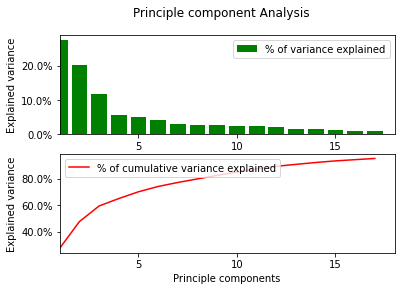

In [16]:
bar_range = pca.n_components_+1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

fig.suptitle('Principle component Analysis')


ax1.bar(list(range(1, bar_range)),pca.explained_variance_ratio_,color='g',label="% of variance explained")
ax1.legend(loc='upper right')


ax2.plot(list(range(1, bar_range)), np.cumsum(pca.explained_variance_ratio_), color='r',label="% of cumulative variance explained")
ax2.legend(loc='upper left')

for ax in [ax1,ax2]:
    ax.set_xlim([1,bar_range])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))
    ax.set_xlabel('Principle components')
    ax.set_ylabel('Explained variance')
    plt.setp(ax, xticks=[s for s in range(1, bar_range) if s%5==0])
    

plt.show()

In [17]:
feature_t = Final_PCA.fit_transform(feature)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, Y_train, Y_test = train_test_split(feature,target,train_size=0.8, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [20]:
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

In [21]:
print('Accuracy R\u00b2 of Linear regression classifier on test set: {:.2f}'.format(model.score(X_test, Y_test)))

Accuracy R² of Linear regression classifier on test set: 0.61


In [22]:
feature_t

array([[-3.84267556e-01, -4.93227400e-01,  6.15246249e-01, ...,
        -1.45892726e-01, -6.22081213e-03,  6.35896419e-03],
       [-3.88097135e-01, -4.80324263e-01,  2.13923888e-01, ...,
        -1.44312256e-01, -6.26136907e-03,  5.63242924e-03],
       [-3.83734105e-01, -4.75786543e-01,  1.69126607e-01, ...,
        -1.28422574e-01, -5.15004776e-03, -3.91412792e-03],
       ...,
       [-8.32975222e-01,  1.06378312e+00,  1.73128540e-01, ...,
        -7.62904919e-02, -1.07253767e-03,  2.45220517e-02],
       [-8.35985200e-01,  1.06594195e+00, -4.74544006e-01, ...,
        -9.65771452e-02,  1.05223175e-04, -6.64905308e-02],
       [-8.31977578e-01,  1.00525854e+00,  3.09322909e-01, ...,
        -1.14439365e-01,  1.88890596e-03, -8.25536623e-02]])

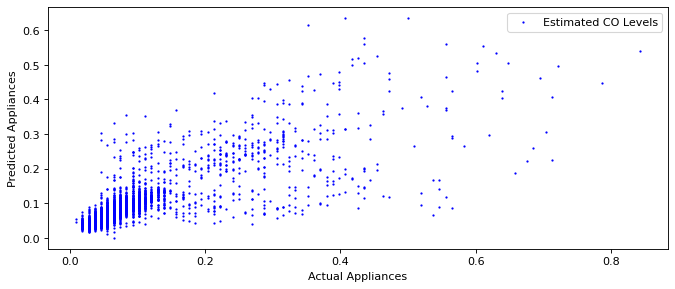

In [23]:
col_name='Appliances'
fig = plt.figure(dpi=80, figsize=(10, 4))
ax = fig.add_subplot(111)
ax.scatter(Y_test, Y_pred, c='b', label='Estimated CO Levels', s = 1)
ax.set_xlabel('Actual '+col_name)
ax.set_ylabel('Predicted '+col_name)
plt.legend()
plt.show()

In [24]:
print("The Prediction R\u00b2 score is {}".format(round(model.score(X_train,Y_train),3)))

The Prediction R² score is 0.585
